# How the Pandemic Changed Conspiracy Theories on Reddit?
### Sentiment Analysis and Topic Modelling
#### Author: Son N. Nguyen

*Find the project repo [here](https://github.com/nszoni/reddit_conspiracy_theories)*


### Table of Contents

1. [Requirements](#requirements)
2. [Hypothesis](#hypothesis)
3. [Data Collection](#collect)
4. [Data Ingestion](#ingestion)
5. [Data Cleaning](#cleaning)
6. [Text Processing](#processing)
7. [Feature Engineering](#engineering)
8. [Feature Extraction](#extraction)
9. [Exploratory Data Analyis (VADER)](#eda)
10. [Sentiment Analysis](#sentiment)
    1. [Distributions](#distributions)
    2. [Emoticon Analyis](#emoticon)
    3. [Wordclouds](#wordcloud)
11. [Entity Analysis](#entity)
12. [Topic Modelling (LDA)](#lda)
13. [Conclusion](#conclusion)

## Requirements <a name="requirements"></a>

To make sure you have all the necessary modules installed, I have created a requirements.txt file.

```
pip install -r requirements.txt

```

### Import the required modules:

In [150]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import warnings
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import emoji
import regex

from tqdm import tqdm
from collections import Counter
from datetime import datetime as dt
from wordcloud import WordCloud
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel


In [152]:
#resize plots
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

#download vader lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nszoni/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Hypothesis <a name="hypothesis"></a>

My hypothesis is that since the pandemic, there has been more activity and discussions have been more aggressive in the r/conspiracy subreddit. To find that out, my idea was to use VADER sentiment intensity analysis to find out how things have changed in the post-covid world.

Besides, I wanted to see using LDA topic modelling whether topics have been shifted from vaccines, global warming, 5G to other, maybe related to the war, the BLM movement, LGBTQ etc. I believe that there is a trend towards the discussion of human rights and questions revolving around media and society.

## Data Collection <a name="collect"></a>

### Kaggle

Initially, my plan was to used a dataset publicly available on [Kaggle](https://www.kaggle.com/datasets/gpreda/reddit-conspiracy-theory). It is claimed to be updated daily but the dataset is relatively small. Since there were no external data sources available out of the box, I decided to scrape it myself from the API.

### Scraping Reddit

The traditional way of scraping Reddit is to use the API with the PRAW wrapper. However, the API is limited to 1000 requests per hour and is not able to scrape historical data defined by a window. This is not enough for our purposes and our data would be highly unbalanced and biased.

> [PRAW](https://github.com/praw-dev/praw), an acronym for "Python Reddit API Wrapper", is a Python package that allows for simple access to Reddit's API.

#### Overcoming limitations of the Reddit API with Pushift API

Luckily there is a service which allows us to scrape historical data from Reddit. The service is called [Pushift API](https://github.com/pushshift/api). Briefly, it let's us control the scraping window. The python wrapper of the API is called PSAW, but there is also a multi-threaded version called PMAW which is more efficient in high volumes close to hundreds of thousands of records.

> “Pushshift makes it much easier for researchers to query and retrieve historical Reddit data, provides extended functionality by providing fulltext search against comments and submissions, and has larger single query limits.” PSAW, meanwhile, makes it easier to work with Pushshift and provides better documentation."

#### Scraping process

I have used a methodology which blends together the usage of the classical PRAW and PSAW. With PSAW, we only get unique idenfiers of submissions from the API bounded by time, which then we feed it to PRAW's submission endpoint. This way, we can get more features offered by PRAW but overcome its limitation of scraping historical data. For a more detailed reference check out this blogpost [here](https://towardsdatascience.com/how-to-collect-a-reddit-dataset-c369de539114).

The script used for scraping can be found in the project's root directory under the name `reddit_pushift_scraper.py`.

## Data Ingestion <a name="ingestion"></a>

I have scraped **2500 submissions between 2018 and 2019** for the analysis of conspiracy theories and subreddit activity. For comparison, I also got submission-level data between **2021 and 2022** which should be the baseline for the aftermath of the global pandemic.

The dataset consists the following columns:
- **id:** unique identifier of the submission
- **author:** author of the submission
- **url:** url of the submission
- **title:** title of the submission
- **score:** number of upvotes
- **created:** UNIX timestamp of the submission
- **body:** body text of the submission

### Pre-covid conspiracy posts between 2018 and 2019

In [153]:
rc_precovid = pd.read_csv('../data/reddit_ct_pushift_2018_2019.csv')
rc_precovid.head()

,id,author,url,title,score,num_comments,created,body
0,ehtfdd,NaN,https://www.youtube.com/watch?v=2vNBLdVjb3c,Christmas in liberated Aleppo,1,2,1.577746e+09,[deleted]
1,ehteog,NaN,https://www.reddit.com/r/conspiracy/comments/e...,Masterpost debunking propaganda about communis...,1,1,1.577745e+09,[removed]
2,ehted0,gibzmedatgoy,https://www.reddit.com/r/conspiracy/comments/e...,What we are experiencing is the return of feud...,33,20,1.577745e+09,"In previous times, and perhaps still today in ..."
3,ehtcmh,polakfury,https://www.youtube.com/watch?v=zGcKURD_osM,The Sackler Family – A Secretive Billion Dolla...,3,2,1.577745e+09,NaN
4,eht8hd,wisperer11,https://www.reddit.com/r/conspiracy/comments/e...,Swarms of drones filling the skies in Nebrasks...,125,106,1.577745e+09,Though there is a veritable infinity of odditi...


### Post-covid top conspiracy post between 2021 and 2022

In [154]:
rc_postcovid = pd.read_csv('../data/reddit_ct_pushift_2021_2022.csv')
rc_postcovid.head()

,id,author,url,title,score,num_comments,created,body
0,ua5ej6,EurekaStockade,https://www.reddit.com/r/conspiracy/comments/u...,"Nuclear Energy--""too cheap to meter""--thats wh...",1,1,1.650720e+09,Before WW2--Globalists realized that cheap nuc...
1,ua58qr,MSA966,https://www.reddit.com/r/conspiracy/comments/u...,Why iPhone face recognition works even though ...,1,2,1.650720e+09,NaN
2,ua55yb,Ancient-Soup2098,https://www.reddit.com/r/conspiracy/comments/u...,Do you think we are the virus?,2,3,1.650720e+09,I’m not necessarily religious/spiritual but I ...
3,ua53xn,jomtienislife,https://youtu.be/DvzqTvafVu0,Russian Ministry of Defense warns of planned p...,0,2,1.650719e+09,NaN
4,ua502a,Mouse1701,https://www.reddit.com/r/conspiracy/comments/u...,Disney world just lost it's government status,4,8,1.650719e+09,Walt Disney world has just lost it's ablilty t...


## Data Cleaning <a name="cleaning"></a>

First, I wanted to label each dataset before concatenating them to segment by the pre-coviid and post-covid data in later analyses. The creation date was given in UNIX time in the raw data which had to be converted into a human-readable format.

In [155]:
# Label dataframes and union

rc_precovid['label'] = 'precovid'
rc_postcovid['label'] = 'postcovid'

rc = pd.concat([rc_precovid, rc_postcovid], axis=0)
rc['timestamp'] = rc['created'].apply(dt.fromtimestamp)

rc.head()

,id,author,url,title,score,num_comments,created,body,label,timestamp
0,ehtfdd,NaN,https://www.youtube.com/watch?v=2vNBLdVjb3c,Christmas in liberated Aleppo,1,2,1.577746e+09,[deleted],precovid,2019-12-30 23:38:29
1,ehteog,NaN,https://www.reddit.com/r/conspiracy/comments/e...,Masterpost debunking propaganda about communis...,1,1,1.577745e+09,[removed],precovid,2019-12-30 23:37:08
2,ehted0,gibzmedatgoy,https://www.reddit.com/r/conspiracy/comments/e...,What we are experiencing is the return of feud...,33,20,1.577745e+09,"In previous times, and perhaps still today in ...",precovid,2019-12-30 23:36:27
3,ehtcmh,polakfury,https://www.youtube.com/watch?v=zGcKURD_osM,The Sackler Family – A Secretive Billion Dolla...,3,2,1.577745e+09,NaN,precovid,2019-12-30 23:32:52
4,eht8hd,wisperer11,https://www.reddit.com/r/conspiracy/comments/e...,Swarms of drones filling the skies in Nebrasks...,125,106,1.577745e+09,Though there is a veritable infinity of odditi...,precovid,2019-12-30 23:24:35


In [156]:
# replace [deleted] or [removed] with empty string so that it does not break the next step
rc['body'] = rc['body'].replace('[deleted]', np.nan)
rc['body'] = rc['body'].replace('[removed]', np.nan)

#### Glue together title and body of a submission

We could either do the analysis separately for post titles and body texts, but it would mean that we lose significant amount of data due to fanning through post which only have a title.

As a result, I have decided to keep the analysis concise and concatenate together the two features. The limitation of this manouver is that there are cases where the titles are just the first line of the body text.

In [157]:
# Concat together title and body text
rc['text'] = rc['title'].fillna('') + ' ' + rc['body'].fillna('')

In [158]:
#drop unnecessary columns
rc.drop(['id', 'url', 'created', 'body', 'title'], axis=1, inplace=True)

rc.head()

,author,score,num_comments,label,timestamp,text
0,NaN,1,2,precovid,2019-12-30 23:38:29,Christmas in liberated Aleppo
1,NaN,1,1,precovid,2019-12-30 23:37:08,Masterpost debunking propaganda about communis...
2,gibzmedatgoy,33,20,precovid,2019-12-30 23:36:27,What we are experiencing is the return of feud...
3,polakfury,3,2,precovid,2019-12-30 23:32:52,The Sackler Family – A Secretive Billion Dolla...
4,wisperer11,125,106,precovid,2019-12-30 23:24:35,Swarms of drones filling the skies in Nebrasks...


In [159]:
# observe missing values in text column
rc['text'].isna().sum()

0

In [160]:
# find values with only spaces
rc[rc['text'].str.strip().str.len() == 0]

,author,score,num_comments,label,timestamp,text


No missing values or whitespaces in our data!

We have in total 5000 submissions.

In [161]:
rc.shape

(5000, 6)

## Text Processing <a name="processing"></a>

#### Extend stopwords corpus

The nltk stopwords corpus is a list of words that are considered irrelevant in the context of text analysis. However, it is not sufficient to remove all irrelevant words from the text as per context. I have arbitarily extended the stopword corpus with words which does not add to the meaning of the text.

In [282]:
#add words to stopword list
stop_words = stopwords.words('english')
stop_words.extend(['use', 'people', 'person', 'like', 'think', 'know', 'case', 'want',
                   'mean', 'one', 'many', 'well', 'two', 'say', 'would', 'make', 'get', 'go', 'thing', 'much', 'time', 'even', 'new', 'also', 'could'])

I have wrote a text processer function which cleans the text from noises (e.g. username handlers, hyperlinks, non-alphabetic elements, whitespaces, etc.) as well as tokenizes the text, removes stopwords and lemmatizes the generated tokens.

In [163]:
lemmatizer = WordNetLemmatizer()

def text_preprocess_lemmatize(text: str) -> str:
    
    '''
    - remove handlers (eg. @username)
    - remove urls
    - remove any non-word elements (inc. punctuation)
    - remove single letters
    - remove digits
    - replace multiple spaces with a single space
    - tokenize text
    - filter out stopwords
    - lemmatize tokens
    - filter out tokens with less than 3 characters
    '''
    garbage = re.compile('@[^\s]+|http\S+|\W|\s+[a-zA-Z]\s+|\d+|\s+')
    
    text = text.lower()
    text= re.sub(garbage,' ', text)
    
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in set(stop_words)]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [word for word in tokens if len(word)>=3]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text 

Applying the text processer, we can see that it did a good job in overall

In [164]:
rc['cleaned'] = rc['text'].apply(text_preprocess_lemmatize)

In [165]:
rc.head()

,author,score,num_comments,label,timestamp,text,cleaned
0,NaN,1,2,precovid,2019-12-30 23:38:29,Christmas in liberated Aleppo,christmas liberated aleppo
1,NaN,1,1,precovid,2019-12-30 23:37:08,Masterpost debunking propaganda about communis...,masterpost debunking propaganda communism comm...
2,gibzmedatgoy,33,20,precovid,2019-12-30 23:36:27,What we are experiencing is the return of feud...,experiencing return feudalism previous time pe...
3,polakfury,3,2,precovid,2019-12-30 23:32:52,The Sackler Family – A Secretive Billion Dolla...,sackler family secretive billion dollar opioid...
4,wisperer11,125,106,precovid,2019-12-30 23:24:35,Swarms of drones filling the skies in Nebrasks...,swarm drone filling sky nebrasks colorado gove...


## Feature Engineering <a name="engineering"></a>

For feature, engineering, we need to generate polarity scores for the submissions. I did that with the help of the VADER lexicon which is suitable for categorizing social media texts with emoticons. I did not apply the sentiment intensity analysis algorithm on the cleaner, lemmatized data, rather used it on the raw text data after filtering out non-alphabetic characters and lowercasing them.

> [VADER](https://github.com/cjhutto/vaderSentiment) is a lexicon and rule-based feeling analysis instrument that is explicitly sensitive to suppositions communicated in web-based media. VADER utilizes a mix of lexical highlights (e.g., words) that are, for the most part, marked by their semantic direction as one or the other positive or negative. Thus, VADER not only tells about the Polarity score yet, in addition, it tells us concerning how positive or negative a conclusion is.

In [166]:
# Apply SIA from Vader package
sid = sia()

# lowercase and remove all non-alphabetic elements and fit polarity scores
rc['sentiments'] = rc['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))

In [167]:
rc.head()

,author,score,num_comments,label,timestamp,text,cleaned,sentiments
0,NaN,1,2,precovid,2019-12-30 23:38:29,Christmas in liberated Aleppo,christmas liberated aleppo,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,NaN,1,1,precovid,2019-12-30 23:37:08,Masterpost debunking propaganda about communis...,masterpost debunking propaganda communism comm...,"{'neg': 0.222, 'neu': 0.778, 'pos': 0.0, 'comp..."
2,gibzmedatgoy,33,20,precovid,2019-12-30 23:36:27,What we are experiencing is the return of feud...,experiencing return feudalism previous time pe...,"{'neg': 0.084, 'neu': 0.769, 'pos': 0.148, 'co..."
3,polakfury,3,2,precovid,2019-12-30 23:32:52,The Sackler Family – A Secretive Billion Dolla...,sackler family secretive billion dollar opioid...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,wisperer11,125,106,precovid,2019-12-30 23:24:35,Swarms of drones filling the skies in Nebrasks...,swarm drone filling sky nebrasks colorado gove...,"{'neg': 0.076, 'neu': 0.9, 'pos': 0.024, 'comp..."


Parse out elements of the dictionary to columns

In [168]:
# Parse out dict elements

rc['positive'] = rc['sentiments'].apply(lambda x: x['pos']) 
rc['neutral'] = rc['sentiments'].apply(lambda x: x['neu'])
rc['negative'] = rc['sentiments'].apply(lambda x: x['neg'])
rc['compound'] = rc['sentiments'].apply(lambda x: x['compound'])

In [169]:
rc.head()

,author,score,num_comments,label,timestamp,text,cleaned,sentiments,positive,neutral,negative,compound
0,NaN,1,2,precovid,2019-12-30 23:38:29,Christmas in liberated Aleppo,christmas liberated aleppo,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
1,NaN,1,1,precovid,2019-12-30 23:37:08,Masterpost debunking propaganda about communis...,masterpost debunking propaganda communism comm...,"{'neg': 0.222, 'neu': 0.778, 'pos': 0.0, 'comp...",0.000,0.778,0.222,-0.2500
2,gibzmedatgoy,33,20,precovid,2019-12-30 23:36:27,What we are experiencing is the return of feud...,experiencing return feudalism previous time pe...,"{'neg': 0.084, 'neu': 0.769, 'pos': 0.148, 'co...",0.148,0.769,0.084,0.9963
3,polakfury,3,2,precovid,2019-12-30 23:32:52,The Sackler Family – A Secretive Billion Dolla...,sackler family secretive billion dollar opioid...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
4,wisperer11,125,106,precovid,2019-12-30 23:24:35,Swarms of drones filling the skies in Nebrasks...,swarm drone filling sky nebrasks colorado gove...,"{'neg': 0.076, 'neu': 0.9, 'pos': 0.024, 'comp...",0.024,0.900,0.076,-0.7341


Based on my online research in determining a compund threshold, I will consider posts with a compound value greater than 0.2 as positive and less than -0.2 as negative. If you choose a higher value, you might get more compact results (less false positives and false negatives), but the size of the results will decrease significantly.

All in-between will be considered as a neutral text.

In [170]:
THRESHOLD = 0.2

conditions = [
    (rc['compound'] <= -THRESHOLD),
    (rc['compound'] > -THRESHOLD) & (rc['compound'] < THRESHOLD),
    (rc['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
rc['sentiment'] = np.select(conditions, values)

In [171]:
rc.head()

,author,score,num_comments,label,timestamp,text,cleaned,sentiments,positive,neutral,negative,compound,sentiment
0,NaN,1,2,precovid,2019-12-30 23:38:29,Christmas in liberated Aleppo,christmas liberated aleppo,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neu
1,NaN,1,1,precovid,2019-12-30 23:37:08,Masterpost debunking propaganda about communis...,masterpost debunking propaganda communism comm...,"{'neg': 0.222, 'neu': 0.778, 'pos': 0.0, 'comp...",0.000,0.778,0.222,-0.2500,neg
2,gibzmedatgoy,33,20,precovid,2019-12-30 23:36:27,What we are experiencing is the return of feud...,experiencing return feudalism previous time pe...,"{'neg': 0.084, 'neu': 0.769, 'pos': 0.148, 'co...",0.148,0.769,0.084,0.9963,pos
3,polakfury,3,2,precovid,2019-12-30 23:32:52,The Sackler Family – A Secretive Billion Dolla...,sackler family secretive billion dollar opioid...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neu
4,wisperer11,125,106,precovid,2019-12-30 23:24:35,Swarms of drones filling the skies in Nebrasks...,swarm drone filling sky nebrasks colorado gove...,"{'neg': 0.076, 'neu': 0.9, 'pos': 0.024, 'comp...",0.024,0.900,0.076,-0.7341,neg


## Feature Extraction <a name="extraction"></a>

### Naive features

Let's carve out some naive metrics like the number of words, stopwords, the average word length, and the number of question marks. My assumption when discussing conspiracy theories, we tend to use more question marks indicating our uncertainty.

In [220]:
rc['num_words'] = rc['text'].apply(lambda x: len(x.split(' ')))
rc['num_stopwords'] = rc['text'].apply(lambda x: len([word for word in x.split(' ') if word in list(stop_words)]))
rc['avg_word_length'] = rc['text'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(stop_words)])))
rc['num_question_mark'] = rc['text'].apply(lambda x: len([va for va in x.split(' ') if va == '?']))
rc['week']  = pd.DatetimeIndex(rc['timestamp']).week
rc['year']  = pd.DatetimeIndex(rc['timestamp']).year
rc['month'] = pd.DatetimeIndex(rc['timestamp']).month

### Emoji features

When analyzing social media data, we cannot skip past the fact that there is a trend towards people expressing themselves through emojis. 

My intention here was to prepare the dataset for analyzing the commonly used emojis across multiple segments (time or sentiment), therefore I have collected all the emojis a submission to a list and added a counter for each.

In [173]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)
    
    return emoji_list

In [174]:
#apply split count to column text
rc['emoji_list'] = rc['text'].apply(split_count)

In [175]:
#count elements in the list
rc['num_emojis'] = rc['emoji_list'].apply(len)

We can see that there even post with 8 or 9 emojis.

In [221]:
rc[rc['num_emojis'] > 5].head()

,author,score,num_comments,label,timestamp,text,cleaned,sentiments,positive,neutral,...,sentiment,num_words,num_stopwords,avg_word_length,num_question_mark,emoji_list,num_emojis,year,month,week
463,elisa_bp101,0,10,postcovid,2022-04-22 18:34:54,JESUS CHRIST is an Alien God that's why he Res...,jesus christ alien god resurrected dead real t...,"{'neg': 0.092, 'neu': 0.774, 'pos': 0.134, 'co...",0.134,0.774,...,pos,397,168,6.069869,0,"[🛡️, 🙄, 😉, 🛸, 🌎, 🕳️, 🌀, 🚽]",8,2022,4,16
987,Hedggiekilla419,11,5,postcovid,2022-04-21 20:08:59,"Regardless of what 💩 MSM is pushing, inflation...",regardless msm pushing inflation caused russia...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,...,neu,26,9,6.000000,0,"[💩, 💯, 🤦, 🖍️, 🍌, 🦧, 🚀, 🌚, 💯]",9,2022,4,16
1615,arnott,7,7,postcovid,2022-04-20 16:34:59,BCG 💩 Victoria’s Secret 👙 Jeffrey Epstein 🧟 Ke...,bcg victoria secret jeffrey epstein kenneth gr...,"{'neg': 0.084, 'neu': 0.916, 'pos': 0.0, 'comp...",0.000,0.916,...,neg,33,8,4.240000,0,"[💩, 👙, 🧟, 🏰, 🧶, 🕸]",6,2022,4,16


## Exploratory Data Analysis <a name="eda"></a>

### How users write posts after the pandemic?

We can make the following remarks based on the barplots below:

- The average word length did not change
- The average number of words used in a post has decreased since COVID
- The average number of question marks has increased since COVID indicating a marginally larger uncertainty
- The average number of emojis within a post also increased suggesting a different way of expression and how emojis became a standard of communication

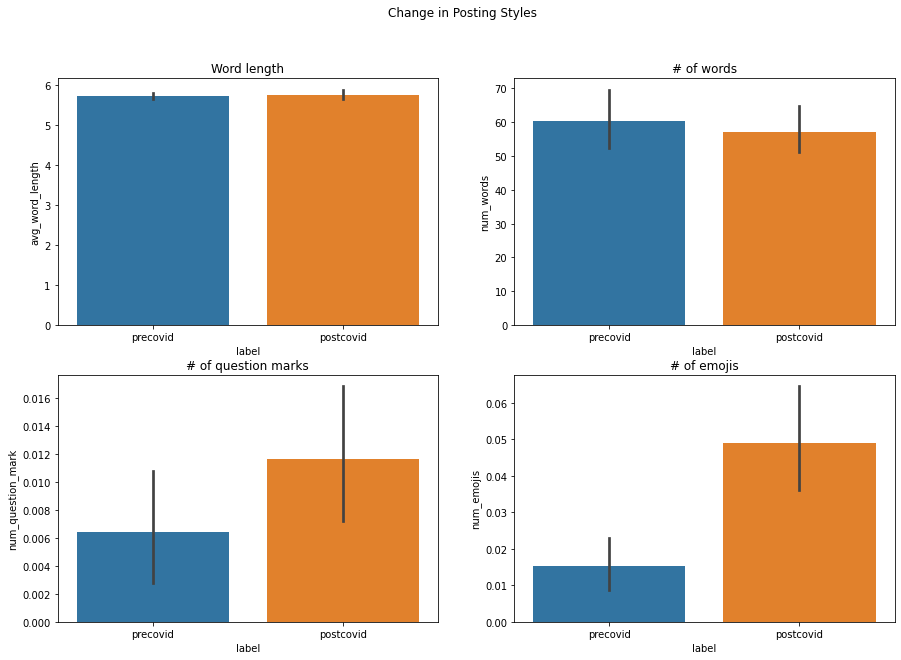

In [225]:
# seaborn boxplot of num_words per label

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Change in Posting Styles')

# average word length
sns.barplot(x='label', y='avg_word_length', data=rc, ax=axes[0,0])
axes[0, 0].set_title('Word length')

# Average number of words
sns.barplot(x='label', y='num_words', data=rc, ax=axes[0,1])
axes[0, 1].set_title('# of words')


# Average number of question marks
sns.barplot(x='label', y='num_question_mark', data=rc, ax=axes[1, 0])
axes[1, 0].set_title('# of question marks')


# Average number of emojis
sns.barplot(x='label', y='num_emojis', data=rc, ax=axes[1, 1])
axes[1, 1].set_title('# of emojis')
plt.show()



### Correlation heatmap

I also wanted to see that among the numerical dimensions of a submission, which metrics correlate with each other. It seems that upvote and comments are moving ahnd-in-hand as there is a positive correlation of 0.76 between them.

Text(0.5, 1.0, 'Correlation Heatmap')

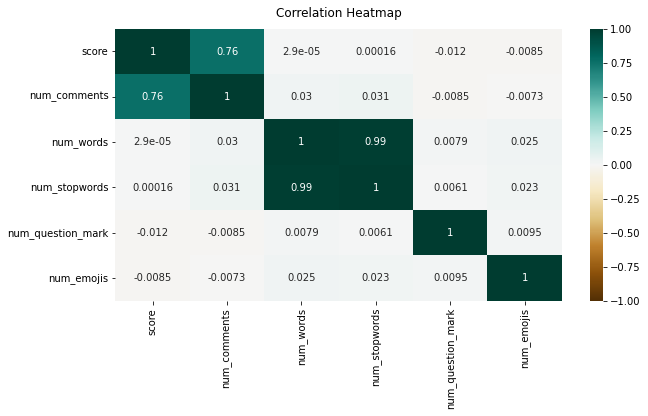

In [207]:
#correlation plot seaborn
corr = rc[['score', 'num_comments', 'num_words', 'num_stopwords', 'num_question_mark', 'num_emojis']].corr()
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

Text(0.5, 1.0, 'Number of Comments vs. Score')

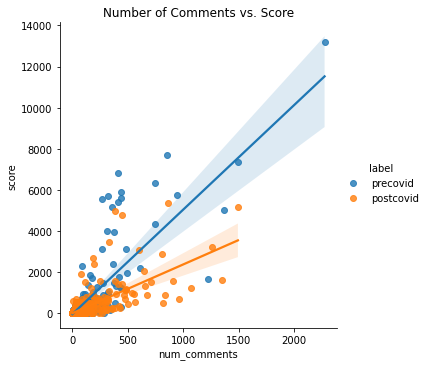

In [305]:
#seaborn scatterplot number of comments and score
sns.lmplot(x='num_comments', y='score', data=rc, hue='label')
plt.title('Number of Comments vs. Score')

## Sentiment Analysis <a name="sentiment"></a>

### Distributions <a name="distributions"></a>

If we look at the distribution of sentiments by period, we can see that the rankings did not change since the pandemic. Negative posts are still dominating the subreddit, but there is a larger number of positve post in the post-covid period.

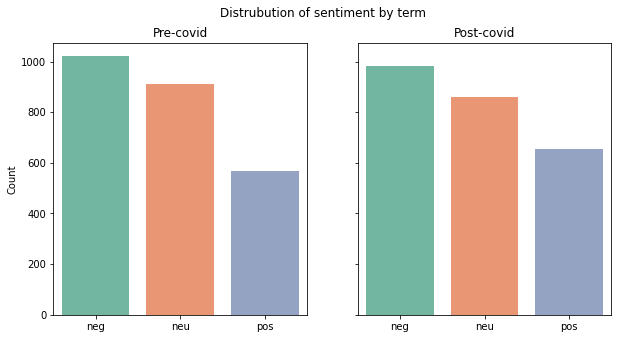

In [304]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.suptitle('Distrubution of sentiment by term')

# Pre-covid
sns.countplot(ax=axes[0], x='sentiment', data=rc[rc['label']=='precovid'], palette='Set2', order=['neg', 'neu', 'pos'])
axes[0].set_title('Pre-covid')
axes[0].set(xlabel=None, ylabel='Count')

# Post-covid
sns.countplot(ax=axes[1], x='sentiment', data=rc[rc['label']=='postcovid'], palette='Set2', order=['neg', 'neu', 'pos'])
axes[1].set_title('Post-covid')
axes[1].set(xlabel=None, ylabel=None)

plt.show()

There is no distignuishable difference between the distrbution of number of words for positive and negative posts.

Text(0.5, 1.0, 'Negative')

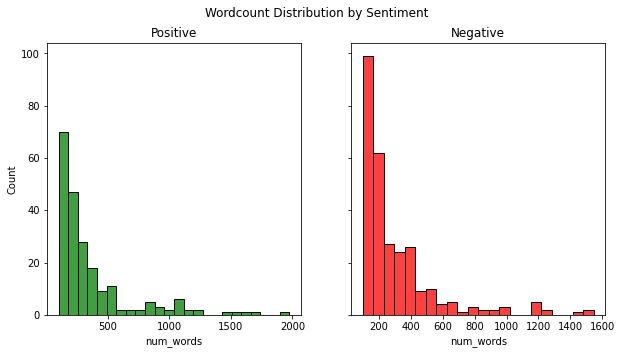

In [227]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.suptitle('Wordcount Distribution by Sentiment')

sns.histplot(rc[(rc['sentiment']=='pos') & (rc['num_words'] > 100) & (rc['num_words'] < 2000)]['num_words'], ax=axes[0],color='green')
axes[0].set_title('Positive')

sns.histplot(rc[(rc['sentiment']=='neg') & (rc['num_words'] > 100) & (rc['num_words'] < 2000)]['num_words'], ax=axes[1],color='red')
axes[1].set_title('Negative')

### Emoticon analysis <a name="emoticon"></a>

I also wanted to investigate which emojis are the most frequenty used per sentiment. For that, I gathered separately all the emoji frequencies for each sentiment.

#### Positive emojis

In [184]:
# generate emoji frequencies for positive posts
pos_counter = Counter()
for item in rc[rc['sentiment'] == 'pos']['emoji_list']:
    pos_counter.update(item)

pos_emojis = pd.DataFrame.from_dict(pos_counter, orient='index').reset_index().rename(columns={'index':'emoji', 0:'count'})

pos_plot = pos_emojis.nlargest(5, 'count')

#### Negative emojis

In [185]:
# generate emoji frequencies for negative posts
neg_counter = Counter()
for item in rc[rc['sentiment'] == 'neg']['emoji_list']:
    neg_counter.update(item)

neg_emojis = pd.DataFrame.from_dict(neg_counter, orient='index').reset_index().rename(columns={'index':'emoji', 0:'count'})

neg_plot = neg_emojis.nlargest(5, 'count')

#### Commonly used emojis per sentiment

I have used plotly to plot the top 5 emojis used per sentiment. It seems that the "Tears of Joy" emoji is commonly used in posts of both sentiments. Besides that, we can recognize the heart emoji in the positive field and multiple emojis indicating uncertainty (e.g. the suspiciously looking eyes emoji, the eyebrow raising, and the thinking emoji).

In [186]:
fig = make_subplots(rows=2, cols=2,
    subplot_titles=("Positive", "Negative"))

fig.add_trace(go.Scatter(y=pos_plot['emoji'],
                x=pos_plot['count'],
                name='Positive Emojis',
                marker_color='white',
                orientation='h',
                text=pos_plot['emoji'],
                textposition='top center',
                mode='markers+text',
                textfont=dict(size=30),
                ), row=1, col=1)

fig.add_trace(go.Scatter(y=neg_plot['emoji'],
                x=neg_plot['count'],
                name='Negative Emojis',
                marker_color='white',
                orientation='h',
                text=neg_plot['emoji'],
                textposition='top center',
                mode='markers+text',
                textfont=dict(size=30),
                ), row=2, col=1)


fig.update_yaxes(visible =False, range=[0, len(pos_plot)+1])
fig.update_xaxes(title='# Usage')

fig.update_layout(height=800, width=800, title_text="Emojis per Sentiment", template='simple_white')
fig.show()

### Wordclouds <a name="wordcloud"></a>

In this section I wanted to display how commonly used words have changed after the pandemic per sentiment.

In [293]:
def display_wordcloud(title, periods, sentiment, cmap):
    fig = plt.figure(figsize=(15, 4))
    for t in range(len(periods)):
        plt.subplot(1, 2, t+1).set_title(periods[t].capitalize())
        plt.plot()
        positive_wc = rc[(rc['sentiment'] == sentiment) & (rc['label'] == periods[t])]
        words = ''
        for sentence in positive_wc['cleaned']:
            words += str(sentence) + ' '
        # Create and generate a word cloud image 
        my_cloud = WordCloud(background_color='white', stopwords=stop_words, max_words=50, colormap=cmap).generate(words)
        plt.imshow(my_cloud, interpolation='bilinear') 
        plt.axis("off")
    fig.suptitle(title)
    plt.show()

#### Positive words

We can see that god, life, world was among the positive words before the pandemic. As per post-covid data, government, human, and covid emerge as popular words.

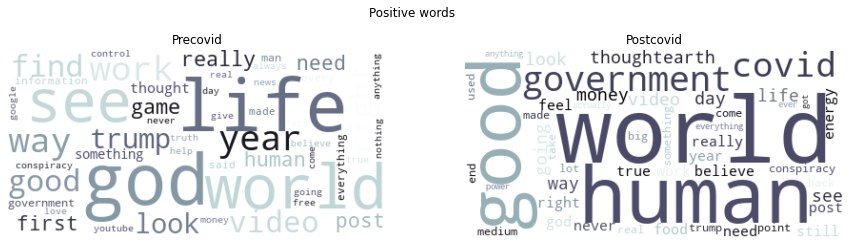

In [298]:
display_wordcloud("Positive words", ['precovid', 'postcovid'], 'pos', 'bone')

#### Negative words

In terms of the negative words, we can see that jew, war, jeffrey epstein, strange creatures appear among the most common ones. The suspected suicide of Jeffrey Epstein was one of the hottest topic that day as well as the UFO footages leaked from Pentagon. In the last year, words connected with the Ukranian war has overshadowed the subreddit such as ukraine, russia, war. It is notable that trump has appeared in all periods and sentiments except positive words after the pandemic

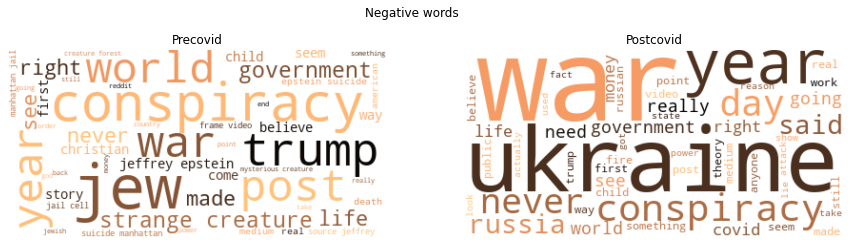

In [299]:
display_wordcloud("Negative words", ['precovid', 'postcovid'], 'neg', 'copper')

## Entity Analyis <a name="entity"></a>

To search meaninful entities, we have took look at multiple words. Therefore, I have used bi and tri-grams to identify the most common joint entities.

In [306]:
# apply countvectorizer
c_vec = CountVectorizer(stop_words=stop_words, ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(rc['cleaned'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

jeffrey epstein, epstein suicide, and suicide manhattan jail all connected to the Epstein case so that's no surprise. The other big topic as said before was the UFO and alien-like creature findings in 2019.

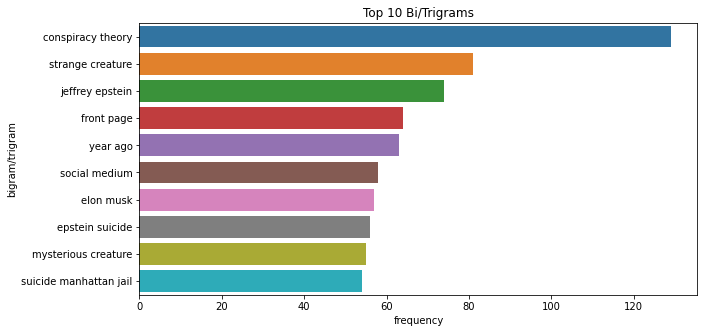

In [349]:
# seaborn barplot top 10 bigrams
fig = sns.barplot(y='bigram/trigram', x='frequency', data=df_ngram.nlargest(10, 'frequency'))
fig.set_title('Top 10 Bi/Trigrams')
plt.show()

## Topic Modelling (LDA) <a name="lda"></a>

Lastly, I wanted to identify topics of discussion before and after the pandemic using Latent Dirichlet Allocation (LDA). I have used the gensim library to implement LDA.

> LDA, short for Latent Dirichlet Allocation is a technique used for topic modelling. Latent means hidden, something that is yet to be found. Dirichlet indicates that the model assumes that the topics in the documents and the words in those topics follow a Dirichlet distribution. Allocation means to giving something, which in this case are topics. LDA assumes that the documents are generated using a statistical generative process, such that each document is a mixture of topics, and each topics are a mixture of words.

### LDA BOG for Pre-covid term

In [324]:
#generate corpuses for lda

pre_corpus = [x.split() for x in rc[rc.label == 'precovid']['cleaned']]

# Create Dictionary 
pre_id2word = corpora.Dictionary(pre_corpus) 

# Convert to bag of words
predoc_term = [pre_id2word.doc2bow(text) for text in pre_corpus] 

### LDA BOG for Post-covid term

In [326]:
#generate corpuses for lda

post_corpus = [x.split() for x in rc[rc.label == 'postcovid']['cleaned']]

# Create Dictionary 
post_id2word = corpora.Dictionary(post_corpus) 

# Convert to bag of words
postdoc_term = [post_id2word.doc2bow(text) for text in post_corpus] 

#### Determine optimal number of topics

According to the best practice, we should choose the number of topics which yields the highest coherence. To experiment with this parameter, I used a custom fucntion which fist the LDA model for a sequence of number of topics and then calculated the coherence score for each model.

In [328]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

We than gather the models and their associated coherence scores.

In [331]:
#precovid
pre_model_list, pre_coherence_values = compute_coherence_values(dictionary=pre_id2word, corpus=predoc_term, texts=pre_corpus, start=2, limit=30, step=5)

#postcovid
post_model_list, post_coherence_values = compute_coherence_values(dictionary=post_id2word, corpus=postdoc_term, texts=post_corpus, start=2, limit=30, step=5)

We then plot the coherence scores and choose the optimal number of topics based on where the curve flattens out. In our case, it is around 15 topics.

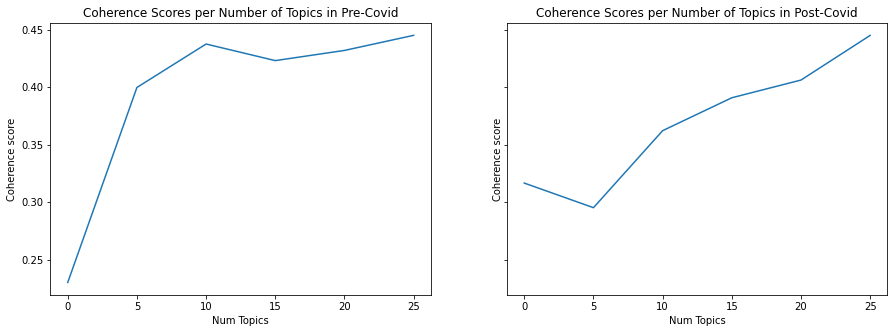

In [338]:
# Show graph
limit=30; start=0; step=5;
x = range(start, limit, step)

f, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

ax[0].plot(x, pre_coherence_values)
ax[0].set_title("Coherence Scores per Number of Topics in Pre-Covid")
ax[0].set_xlabel("Num Topics")
ax[0].set_ylabel("Coherence score")

ax[1].plot(x, post_coherence_values)
ax[1].set_title("Coherence Scores per Number of Topics in Post-Covid")
ax[1].set_xlabel("Num Topics")
ax[1].set_ylabel("Coherence score")

plt.show()

Using that information, we set the `num_topics` parameter to 10 and 15 for pre and post covid corpus respectively. The number of elements (`chunksize` parameter) used in each training chunk is going to be 2000 which is approximately 80% of the raw dataset. Lastly, we are going to iterate through each training chunk 10 times with the `passes` parameter to make sure that our results are accurate.

In [341]:
pre_lda_model = gensim.models.ldamodel.LdaModel(corpus=predoc_term,
                                           id2word=pre_id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=2000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

post_lda_model = gensim.models.ldamodel.LdaModel(corpus=postdoc_term,
                                           id2word=post_id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=2000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)                              

### Conspiracy Topics Before COVID19

We can see that the topics are ranging from aliens to politics connected with Trump. The topics with the smallest marginal topics distribution (around only 5% from total) were topics revolving around the following themes:

- Cluster 6: Alien and UFO discoveries by the Pentagon
- Cluster 7: Russia, CIA and national security
- Cluster 9: Trump's impeachment,
- Cluster 8: The sexual assault cases of celebrities like Kevin Spacey,
- Cluster 10: Controversial political candidates like Gabbard Tulsi, Hillary Clinton, Ghislaine Maxwell (involved in the Epstein case)

In [346]:
#ignore deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#plot topics
pyLDAvis.enable_notebook()
pre_vis = gensimvis.prepare(pre_lda_model, predoc_term, pre_id2word)
pre_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.170291  0.101168       1        1  38.176458
0     -0.149739  0.034806       2        1  14.702395
4     -0.058211 -0.009726       3        1  13.311511
9     -0.047115 -0.012779       4        1   8.451717
7     -0.083275 -0.046784       5        1   7.508205
8      0.179252  0.241405       6        1   5.406807
1      0.072029 -0.095566       7        1   3.384019
3      0.126750 -0.085532       8        1   3.337124
5      0.071787 -0.054224       9        1   3.008706
2      0.058811 -0.072768      10        1   2.713057, topic_info=          Term        Freq       Total Category  logprob  loglift
1332  creature  218.000000  218.000000  Default  30.0000  30.0000
884      alien  199.000000  199.000000  Default  29.0000  29.0000
2237   strange  119.000000  119.000000  Default  28.0000  28.0000
2493   tourist  118.000000  118.000000  Default  27.0000  27.0000
728      trump  289.000000  289.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
268       time    6.502113  297.249512  Topic10  -5.7330  -0.2154
253      state    6.024895  118.657444  Topic10  -5.8092   0.6268
195     police    5.451375   42.387957  Topic10  -5.9092   1.5561
2118   release    5.164782   19.166180  Topic10  -5.9632   2.2958
719       post    5.402759  183.726343  Topic10  -5.9182   0.0806

[625 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
949       1  0.143872  account
949       2  0.319715  account
949       3  0.015986  account
949       4  0.127886  account
949       5  0.111900  account
...     ...       ...      ...
1193      1  0.909873  youtube
1193      4  0.047062  youtube
1193      6  0.031375  youtube
3250      3  0.985499  zionist
1117      7  0.824951     zone

[1367 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 5, 10, 8, 9, 2, 4, 6, 3])

### Conspiracy Topics After COVID19

After the pandemic, topics are now ranging from the Ukranian war through Australian earthquakes to Elon Musk. We can see frequent topics about Australians and Canadians which refer to the strict vaccine requirements imposed by governments. Some tokens may have been misleading as white can indicate a racial topic or topics connected to the White House.

- Cluster 9: Russian and Ukranian conflict which involves Sweden supporting Ukraine and a potential nuclear war,
- Cluster 10: Censorship and political correctness
- Cluster 11: Social media consumption
- Cluster 12: The absurdity of Canadian truckers' protest for COVID19 freedom since the government requiring 3 doses contra the Ukranian struggles which divide communities on whom to support.
- Cluster 13: LSD Nazi conspiracy: Nazi scientists helped the US to test LSD on Soviets
- Cluster 14: Elon Musk's intention to buy Twitter
- Cluster 15: Earthquakes at St. Thomas and other natural disasters


In [347]:
#ignore deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#plot topics
pyLDAvis.enable_notebook()
post_vis = gensimvis.prepare(post_lda_model, postdoc_term, post_id2word)
post_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.168851 -0.090795       1        1  20.473620
7     -0.176655 -0.030792       2        1  15.733482
8     -0.151888 -0.052820       3        1  14.426862
4     -0.111654  0.025990       4        1   7.315664
6     -0.031152  0.163311       5        1   7.164426
9     -0.046073  0.084202       6        1   5.083044
2      0.024577 -0.064501       7        1   4.623581
0     -0.028206  0.057550       8        1   3.978574
11     0.052978  0.016955       9        1   3.457669
12     0.112136 -0.168788      10        1   3.400878
10     0.081181  0.015799      11        1   3.246676
3      0.119142  0.012880      12        1   3.084931
1      0.123217 -0.061229      13        1   2.994833
13     0.105616  0.021958      14        1   2.798973
5      0.095633  0.070282      15        1   2.216786, topic_info=             Term        Freq       Total Category  logprob  loglift
59         energy  105.000000  105.000000  Default  30.0000  30.0000
688    conspiracy  233.000000  233.000000  Default  29.0000  29.0000
10814         lsd   61.000000   61.000000  Default  28.0000  28.0000
333    government  156.000000  156.000000  Default  27.0000  27.0000
1024     democrat   68.000000   68.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1879          ufo    6.951842   17.139591  Topic15  -5.4259   2.9067
1254        funny    6.615565   15.867156  Topic15  -5.4755   2.9343
347         known    7.114294   31.738655  Topic15  -5.4028   2.3137
688    conspiracy    7.523721  233.897232  Topic15  -5.3469   0.3723
178        theory    7.333922  142.537824  Topic15  -5.3724   0.8420

[991 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1402      1  0.338101     abuse
1402     10  0.135240     abuse
1402     12  0.473342     abuse
1402     14  0.033810     abuse
2537      1  0.044410  academic
...     ...       ...       ...
2507      1  0.391752      zero
2507      2  0.055965      zero
2507      8  0.055965      zero
2507     11  0.559645      zero
7200     13  0.874732    zodiac

[2442 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 8, 9, 5, 7, 10, 3, 1, 12, 13, 11, 4, 2, 14, 6])

# Conclusion <a name="lda"></a>

We have seen how posting styles, words have changed over the time. We observed emojis frequently used in positive and negative texts. Lastly, we have identified the topic shifts before and after the pandemic. My hypothesis partly hold because the big picture is almost identical in terms of topics - Politics, Russia, Trump, celebrities, and so on. However, new topics have came up concerning media censorship, social media consumption, and digitalization which are very likely to be part of the covid aftermath, where people have moved online.